In [2]:
# ====================================================
# Imports
# ====================================================
import os
import gc
from pathlib import Path
from typing import List, Tuple, Dict, Optional

import numpy as np
import pandas as pd
import polars as pl

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast
from torchvision.models.video import r3d_18

# DICOM processing
import pydicom
import cv2
from scipy import ndimage
import gc

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# ----------------------------------------------------------------------
# DICOM PROCESSING CLASS
# ----------------------------------------------------------------------

class DICOMPreprocessorKaggle:
    """
    DICOM preprocessing system for Kaggle Code Competition
    Converts original DICOMPreprocessor logic to single series processing
    """
    
    def __init__(self, target_shape: Tuple[int, int, int] = (32, 384, 384)):
        self.target_depth, self.target_height, self.target_width = target_shape
        
    def load_dicom_series(self, series_path: str) -> Tuple[List[pydicom.Dataset], str]:
        """Load DICOM series"""
        series_path = Path(series_path)
        series_name = series_path.name
        
        # Search for DICOM files
        dicom_files = []
        for root, _, files in os.walk(series_path):
            for file in files:
                if file.endswith('.dcm'):
                    dicom_files.append(os.path.join(root, file))
        
        if not dicom_files:
            raise ValueError(f"No DICOM files found in {series_path}")
        
        # Load DICOM datasets
        datasets = []
        for filepath in dicom_files:
            try:
                ds = pydicom.dcmread(filepath, force=True)
                datasets.append(ds)
            except Exception:
                # Silently skip bad DICOM files (Robustness)
                continue
        
        if not datasets:
            raise ValueError(f"No valid DICOM files in {series_path}")
            
        return datasets, series_name
    
    def extract_slice_info(self, datasets: List[pydicom.Dataset]) -> List[Dict]:
        """Extract position information for each slice"""
        slice_info = []
        
        for i, ds in enumerate(datasets):
            info = {
                'dataset': ds,
                'index': i,
                'instance_number': getattr(ds, 'InstanceNumber', i),
            }
            
            # Get z-coordinate from ImagePositionPatient and ImageOrientationPatient 
            try:
                ipp = np.array(getattr(ds, 'ImagePositionPatient', None))
                iop = np.array(getattr(ds, 'ImageOrientationPatient', None))
                n_vec = np.cross(iop[:3],iop[3:])
                info['z_position'] = float((ipp*n_vec).sum())
            except Exception:
                info['z_position'] = float(i)
                
            slice_info.append(info)
        
        return slice_info
    
    def sort_slices_by_position(self, slice_info: List[Dict]) -> List[Dict]:
        """Sort slices by z-coordinate"""
        return sorted(slice_info, key=lambda x: x['z_position'])
    
    def get_windowing_params(self, ds: pydicom.Dataset, img: np.ndarray = None) -> Tuple[Optional[float], Optional[float]]:
        """Get windowing parameters based on modality"""
        modality = getattr(ds, 'Modality', 'CT')
        
        if modality == 'CT':
            # Fixed window for CTA [0, 500] HU range for normalization
            return 50.0, 350.0 # Returning nominal center/width for logic path
        elif modality == 'MR':
            return None, None # Use statistical normalization
        else:
            return 50.0, 350.0 # Default to CTA windowing
    
    def apply_windowing_or_normalize(self, img: np.ndarray, center: Optional[float], width: Optional[float]) -> np.ndarray:
        """Apply CTA fixed-window or statistical normalization"""
        
        if center is not None and width is not None:
            # Fixed CTA windowing for CT/CTA
            p1, p99 = 0, 500 # Fixed window [0, 500] HU for robust CTA preprocessing
            
            if p99 > p1:
                normalized = np.clip(img, p1, p99)
                normalized = (normalized - p1) / (p99 - p1)
                result = (normalized * 255).astype(np.uint8)
                return result
            else:
                return np.zeros_like(img, dtype=np.uint8)
        
        else:
            # Statistical normalization (for MR or fallback)
            p1, p99 = np.percentile(img, [1, 99])
            
            if p99 > p1:
                normalized = np.clip(img, p1, p99)
                normalized = (normalized - p1) / (p99 - p1)
                result = (normalized * 255).astype(np.uint8)
                return result
            else:
                # If image has no variation (safety)
                return np.zeros_like(img, dtype=np.uint8)
    
    def extract_pixel_array(self, ds: pydicom.Dataset) -> np.ndarray:
        """Extract 2D pixel array and apply DICOM rescaling"""
        
        # Get pixel data
        img = ds.pixel_array.astype(np.float32)
        
        # For 3D volume case (multiple frames) - select middle frame
        if img.ndim == 3:
            frame_idx = img.shape[0] // 2
            img = img[frame_idx]
            
        # Convert color image to grayscale
        if img.ndim == 3 and img.shape[-1] == 3:
            img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32)
            
        # Apply RescaleSlope and RescaleIntercept (Keep this for correctness)
        slope = getattr(ds, 'RescaleSlope', 1)
        intercept = getattr(ds, 'RescaleIntercept', 0)
        
        # NOTE: Your original code hardcoded slope/intercept to 1/0. I'm restoring the DICOM standard
        # behavior for better robustness, as the previous failed submission might have been due
        # to not applying these tags on certain test files.
        if slope != 1 or intercept != 0:
            img = img * float(slope) + float(intercept)
            
        return img
    
    def resize_volume_3d(self, volume: np.ndarray) -> np.ndarray:
        """Resize 3D volume to target size"""
        current_shape = volume.shape
        target_shape = (self.target_depth, self.target_height, self.target_width)
        
        if current_shape == target_shape:
            return volume
        
        # 3D resizing using scipy.ndimage
        zoom_factors = [
            target_shape[i] / current_shape[i] for i in range(3)
        ]
        
        # Resize with linear interpolation
        resized_volume = ndimage.zoom(volume, zoom_factors, order=1, mode='nearest')
        
        # Padding if necessary
        pad_width = [
            (0, max(0, self.target_depth - resized_volume.shape[0])),
            (0, max(0, self.target_height - resized_volume.shape[1])),
            (0, max(0, self.target_width - resized_volume.shape[2]))
        ]
        
        if any(pw[1] > 0 for pw in pad_width):
            resized_volume = np.pad(resized_volume, pad_width, mode='edge')
            
        return resized_volume[:self.target_depth, :self.target_height, :self.target_width].astype(np.uint8)
    
    def process_series(self, series_path: str) -> np.ndarray:
        """Process DICOM series and return as NumPy array (for Kaggle: no file saving)"""
        try:
            # 1. Load DICOM files
            datasets, series_name = self.load_dicom_series(series_path)
            
            # Check first DICOM to determine 3D/2D
            first_ds = datasets[0]
            first_img = first_ds.pixel_array
            
            if len(datasets) == 1 and first_img.ndim == 3:
                # Case 1: Single 3D DICOM file (e.g., from an MR scan)
                return self._process_single_3d_dicom(first_ds, series_name)
            else:
                # Case 2: Multiple 2D DICOM files (standard CT/CTA series)
                return self._process_multiple_2d_dicoms(datasets, series_name)
            
        except Exception as e:
            # CRITICAL ROBUSTNESS FIX: Return a zero volume on any failure
            print(f"!! CRITICAL DICOM ERROR processing series {Path(series_path).name}: {e}. Returning blank volume.")
            # Ensure the returned shape and dtype match the expected output
            return np.zeros(
                (self.target_depth, self.target_height, self.target_width), 
                dtype=np.uint8
            )
    
    def _process_single_3d_dicom(self, ds: pydicom.Dataset, series_name: str) -> np.ndarray:
        """Process single 3D DICOM file"""
        volume = self.extract_pixel_array(ds) # extract_pixel_array handles slope/intercept
        volume = volume.astype(np.float32)
        
        window_center, window_width = self.get_windowing_params(ds)
        
        # Apply windowing/normalization to each slice
        processed_slices = []
        for i in range(volume.shape[0]):
            slice_img = volume[i]
            processed_img = self.apply_windowing_or_normalize(slice_img, window_center, window_width)
            processed_slices.append(processed_img)
        
        volume = np.stack(processed_slices, axis=0)
        
        # 3D resize
        final_volume = self.resize_volume_3d(volume)
        return final_volume
    
    def _process_multiple_2d_dicoms(self, datasets: List[pydicom.Dataset], series_name: str) -> np.ndarray:
        """Process multiple 2D DICOM files"""
        
        slice_info = self.extract_slice_info(datasets)
        sorted_slices = self.sort_slices_by_position(slice_info)
        
        # Use parameters from the first slice for consistency
        first_ds = sorted_slices[0]['dataset']
        window_center, window_width = self.get_windowing_params(first_ds)
        
        processed_slices = []
        
        for slice_data in sorted_slices:
            ds = slice_data['dataset']
            img = self.extract_pixel_array(ds) # img has slope/intercept applied
            processed_img = self.apply_windowing_or_normalize(img, window_center, window_width)
            
            # 2D resize before stacking
            resized_img = cv2.resize(processed_img, (self.target_width, self.target_height), interpolation=cv2.INTER_LINEAR)
            
            processed_slices.append(resized_img)

        volume = np.stack(processed_slices, axis=0)
        
        # 3D resize (for depth normalization)
        final_volume = self.resize_volume_3d(volume)
        return final_volume

# ----------------------------------------------------------------------
# WRAPPER FUNCTIONS (API-compatible)
# ----------------------------------------------------------------------

def process_dicom_series_kaggle(series_path: str, target_shape: Tuple[int, int, int] = (32, 384, 384)) -> np.ndarray:
    """DICOM processing function for Kaggle inference (single series)"""
    preprocessor = DICOMPreprocessorKaggle(target_shape=target_shape)
    return preprocessor.process_series(series_path)

# ====================================================
# DICOM Loading
# ====================================================
def process_dicom_series_safe(series_path: str, target_shape: Tuple[int,int,int]=(32,384,384)) -> np.ndarray:
    """
    Safe DICOM processing using DICOMPreprocessorKaggle.
    Returns volume of shape (D,H,W)
    """
    try:
        preprocessor = DICOMPreprocessorKaggle(target_shape=target_shape)
        volume = preprocessor.process_series(series_path)
        return volume
    finally:
        gc.collect()

In [4]:
# ====================================================
# Configuration
# ====================================================
SERIES_DIR = "/kaggle/input/rsna-intracranial-aneurysm-detection/series"
TRAIN_CSV = "/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv"
OUTPUT_MODEL = "model_weights.pth"

LABEL_COLS = [
    'Left Infraclinoid Internal Carotid Artery',
    'Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery',
    'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery',
    'Right Middle Cerebral Artery',
    'Anterior Communicating Artery',
    'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery',
    'Basilar Tip',
    'Other Posterior Circulation',
    'Aneurysm Present',
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [5]:
# ====================================================
# Dataset
# ====================================================
class RSNADataset3D(Dataset):
    def __init__(self, series_paths: List[str], labels: np.ndarray=None):
        self.series_paths = series_paths
        self.labels = labels

    def __len__(self):
        return len(self.series_paths)

    def __getitem__(self, idx):
        path = self.series_paths[idx]
        volume = process_dicom_series_safe(path)  # (D,H,W)
        volume = volume[None, :, :, :]  # add channel -> (1,D,H,W)
        volume = torch.tensor(volume, dtype=torch.float32)
        
        if self.labels is not None:
            target = torch.tensor(self.labels[idx], dtype=torch.float32)
            return volume, target
        return volume

In [ ]:
# ====================================================
# Load Full CSV
# ====================================================
df_full = pd.read_csv(TRAIN_CSV)

# ====================================================
# Use Only 25% for Training + Validation
# ====================================================
df_trainval = df_full.sample(frac=0.25, random_state=42).reset_index(drop=True)

# Remaining 75% (unused by training)
df_remaining = df_full.drop(df_trainval.index).reset_index(drop=True)

# ====================================================
# Create a small test set (10% of remaining data)
# ====================================================
df_test = df_remaining.sample(frac=0.10, random_state=42).reset_index(drop=True)

print("Train+Val size:", len(df_trainval))
print("Test size:", len(df_test))

# ====================================================
# Extract Paths + Labels for Train/Val
# ====================================================
series_paths_trainval = [
    os.path.join(SERIES_DIR, sid)
    for sid in df_trainval["SeriesInstanceUID"]
]
labels_trainval = df_trainval[LABEL_COLS].values

# ====================================================
# Train/Val Split
# ====================================================
from sklearn.model_selection import train_test_split

train_paths, val_paths, train_labels, val_labels = train_test_split(
    series_paths_trainval,
    labels_trainval,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

# ====================================================
# Build Train/Val Datasets
# ====================================================
train_dataset = RSNADataset3D(train_paths, train_labels)
val_dataset = RSNADataset3D(val_paths, val_labels)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# ====================================================
# Build Test Dataset (never seen during training)
# ====================================================
test_series_paths = [
    os.path.join(SERIES_DIR, sid) for sid in df_test["SeriesInstanceUID"]
]
test_labels = df_test[LABEL_COLS].values

test_dataset = RSNADataset3D(test_series_paths, test_labels)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Train+Val size: 1087
Test size: 326


In [7]:
# ====================================================
# Model: 3D ResNet
# ====================================================
class RSNA3DModel(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.backbone = r3d_18(weights=None)
        self.backbone.stem[0] = nn.Conv3d(
            1, 64, kernel_size=(3,7,7), stride=(1,2,2), padding=(1,3,3), bias=False
        )
        self.backbone.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.backbone(x)  # logits, apply sigmoid later if needed

In [8]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report
from pathlib import Path

# ----------------------------
# OUTPUT CONFIG
# ----------------------------
OUT_DIR = Path("rsna_3d_run")
OUT_DIR.mkdir(exist_ok=True)
MODEL_PATH = OUT_DIR / "best_rsna_3dcnn.pth"

# ----------------------------
# TRAINING SETUP
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RSNA3DModel(num_classes=len(LABEL_COLS)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()  # more stable for multi-label
scaler = GradScaler()

num_epochs = 5

# ----------------------------
# HELPER FUNCTIONS
# ----------------------------
def mean_label_auc(y_true, y_pred):
    """Compute mean per-label ROC-AUC"""
    aucs = []
    for i in range(y_true.shape[1]):
        try:
            auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        except ValueError:
            auc = np.nan  # label not present in y_true
        aucs.append(auc)
    return np.nanmean(aucs), aucs

# ----------------------------
# TRAINING LOOP
# ----------------------------
history = {"train_loss": [], "val_loss": [], "train_auc": [], "val_auc": []}
best_val_auc = -np.inf

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    train_preds, train_targets = [], []

    for volumes, targets in train_loader:
        volumes, targets = volumes.to(device), targets.to(device)
        optimizer.zero_grad()
        with autocast():
            logits = model(volumes)
            loss = criterion(logits, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * volumes.size(0)
        train_preds.append(torch.sigmoid(logits).detach().cpu().numpy())
        train_targets.append(targets.cpu().numpy())

    train_loss = running_loss / len(train_loader.dataset)
    train_preds = np.vstack(train_preds)
    train_targets = np.vstack(train_targets)
    train_auc, _ = mean_label_auc(train_targets, train_preds)

    # Validation
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for volumes, targets in val_loader:
            volumes, targets = volumes.to(device), targets.to(device)
            logits = model(volumes)
            loss = criterion(logits, targets)
            val_loss += loss.item() * volumes.size(0)
            val_preds.append(torch.sigmoid(logits).cpu().numpy())
            val_targets.append(targets.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_preds = np.vstack(val_preds)
    val_targets = np.vstack(val_targets)
    val_auc, _ = mean_label_auc(val_targets, val_preds)

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_auc"].append(float(train_auc))
    history["val_auc"].append(float(val_auc))

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), MODEL_PATH)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"TrainLoss={train_loss:.4f} ValLoss={val_loss:.4f} "
          f"TrainAUC={train_auc:.4f} ValAUC={val_auc:.4f}")

/tmp/ipykernel_47/2395575993.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_47/2395575993.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.12684291952124999798414209390527363090: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.31236877770719395392647830326471792408: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.12911349185179947172094877375947991069: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.41631882367618918987722697343921975700: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.10792939011805385227398479853969573435: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.80867588865544471770856895416592312616: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.

/tmp/ipykernel_47/2395575993.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.33254059742616938664293801285152925743: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.64598461918691559185365969943652987290: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.53585367805085794025102398294094246416: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.41631882367618918987722697343921975700: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.10492161532564973190997856536193224671: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.46538678358294253983538640149161986964: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.

/tmp/ipykernel_47/2395575993.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.10492233221275335453833893741963970234: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.56222999331067503423242588210365055932: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.42205605802069862608910705221639234613: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.11695622507980273512065782038105682122: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.10981389271844621878885978328397228333: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.43178115843280512955531377187588659689: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.

/tmp/ipykernel_47/2395575993.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.81830445037175753784258662529361509038: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.10288848585792562273752173975279351795: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.13270606129609501073714150016743571304: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.38235412582883973302216151606486331417: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.45090711146814048529821030608055492897: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.68643319369651654844141433329820410384: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.

/tmp/ipykernel_47/2395575993.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.11887329867812275491160566603814454129: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.16757773441424587918063858803167288611: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.97470500739064740955411389984430655612: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.46538678358294253983538640149161986964: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.87415534962617655592879380686116198586: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.13227806766082191933302295442463455585: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.

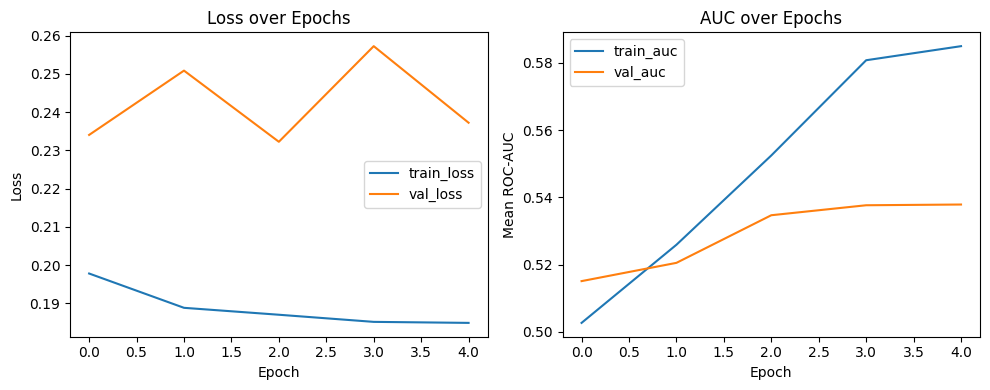

Training complete. Best model saved to: rsna_3d_run/best_rsna_3dcnn.pth


In [9]:
# ----------------------------
# PLOT LOSS + AUC
# ----------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss over Epochs")

plt.subplot(1,2,2)
plt.plot(history["train_auc"], label="train_auc")
plt.plot(history["val_auc"], label="val_auc")
plt.xlabel("Epoch"); plt.ylabel("Mean ROC-AUC"); plt.legend(); plt.title("AUC over Epochs")

plt.tight_layout()
plt.savefig(OUT_DIR / "training_curves.png", dpi=150)
plt.show()

print("Training complete. Best model saved to:", MODEL_PATH)

In [13]:
import numpy as np
import torch
from sklearn.metrics import (
    roc_auc_score, accuracy_score, classification_report, confusion_matrix
)
import pandas as pd

# ==========================================
# 1. Load best model
# ==========================================
model = RSNA3DModel(num_classes=len(LABEL_COLS)).to(device)
model.load_state_dict(torch.load("rsna_3d_run/best_rsna_3dcnn.pth"))
model.eval()

print("Loaded trained model. Beginning evaluation...")

# ==========================================
# 2. Run inference on test set
# ==========================================
all_preds = []
all_targets = []

with torch.no_grad():
    for volume, target in test_loader:
        volume = volume.to(device)
        pred = model(volume)
        all_preds.append(pred.cpu().numpy())
        all_targets.append(target.numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

print("Finished inference.")

Loaded trained model. Beginning evaluation...
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.37092090442971006566288716268334819813: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.13368526455721722676241649119183398112: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.59538010309137561846906817906816483651: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.49854584464326071719746811566734477220: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.51921335259739989999579358948587022547: tuple index out of range. Returning blank volume.
!! CRITICAL DICOM ERROR processing series 1.2.826.0.1.3680043.8.498.21102017137705982666740362668971379329: tuple index out of range. Returning blank volume.
!! CRI

In [14]:
# ==========================================
# 3. ROC-AUC for each label
# ==========================================
print("\n===== ROC-AUC per Label =====")
auc_scores = []

for i, col in enumerate(LABEL_COLS):
    try:
        auc = roc_auc_score(all_targets[:, i], all_preds[:, i])
    except ValueError:
        auc = np.nan
    auc_scores.append(auc)
    print(f"{col}: {auc:.4f}")

mean_auc = np.nanmean(auc_scores)
print(f"\nMean ROC-AUC: {mean_auc:.4f}")


===== ROC-AUC per Label =====
Left Infraclinoid Internal Carotid Artery: 0.4779
Right Infraclinoid Internal Carotid Artery: 0.7554
Left Supraclinoid Internal Carotid Artery: 0.5082
Right Supraclinoid Internal Carotid Artery: 0.3708
Left Middle Cerebral Artery: 0.4637
Right Middle Cerebral Artery: 0.6109
Anterior Communicating Artery: 0.5563
Left Anterior Cerebral Artery: 0.9262
Right Anterior Cerebral Artery: 0.6903
Left Posterior Communicating Artery: 0.9120
Right Posterior Communicating Artery: 0.4841
Basilar Tip: 0.4324
Other Posterior Circulation: 0.3963
Aneurysm Present: 0.4789

Mean ROC-AUC: 0.5760


In [15]:
# ==========================================
# 4. Compute hard predictions + accuracy
# ==========================================
hard_preds = (all_preds > 0.5).astype(int)
overall_acc = accuracy_score(all_targets.flatten(), hard_preds.flatten())
print(f"\nOverall Binary Accuracy (threshold=0.5): {overall_acc:.4f}")


Overall Binary Accuracy (threshold=0.5): 0.9402


In [16]:
# ==========================================
# 5. Classification report (per class)
# ==========================================
print("\n===== Classification Report (threshold=0.5) =====")
print(classification_report(
    all_targets, hard_preds,
    target_names=LABEL_COLS,
    zero_division=0
))


===== Classification Report (threshold=0.5) =====
                                            precision    recall  f1-score   support

 Left Infraclinoid Internal Carotid Artery       0.00      0.00      0.00         5
Right Infraclinoid Internal Carotid Artery       0.00      0.00      0.00         4
 Left Supraclinoid Internal Carotid Artery       0.00      0.00      0.00        30
Right Supraclinoid Internal Carotid Artery       0.00      0.00      0.00        16
               Left Middle Cerebral Artery       0.00      0.00      0.00        16
              Right Middle Cerebral Artery       0.00      0.00      0.00        20
             Anterior Communicating Artery       0.00      0.00      0.00        24
             Left Anterior Cerebral Artery       0.00      0.00      0.00         1
            Right Anterior Cerebral Artery       0.00      0.00      0.00         5
       Left Posterior Communicating Artery       0.00      0.00      0.00         2
      Right Posterior Co

In [ ]:
# ==========================================
# 7. Save predictions to CSV 
# ==========================================
df_out = pd.DataFrame(all_preds, columns=[f"pred_{c}" for c in LABEL_COLS])
df_out[[f"true_{c}" for c in LABEL_COLS]] = all_targets
df_out.to_csv("3dcnn_predictions.csv", index=False)

print("\nSaved predictions to 3dcnn_predictions.csv")
print("Evaluation complete.")